## **Import library**

In [72]:
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pyod.models.iforest import IForest 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR 
from scipy.stats import uniform as sp_rand 
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy 
import yfinance 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.precision',4)
pd.set_option('display.float_format',  '{:,.4}'.format)

sns.set_style('darkgrid')
plt.rc('figure', figsize=(16,6))
plt.rc('font', family = 'sans-serif')


## **Functions**

In [114]:
def fontdict(fontsize=20, fontweight='bold'):
  return {'fontsize':fontsize, 'fontweight':fontweight}

def set_frame_style(df,caption=''):
  return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{'selector':'caption','props':[('color','White'),('font-size','16px'),('font-weight','bold'),('text-align','left')]}])

## **Data Description**

The dataset comprises the S&P 500 index data spanning a 5-day week, beginning from April 6, 2009, through December 31, 2020

In [3]:
raw_data = yfinance.download(tickers= '^GSPC', start='2009-04-06', end = '2020-12-31')
df = raw_data.copy()
display(set_frame_style(df.head(5)))

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-06 00:00:00,839.750000,839.750000,822.789978,835.479980,835.479980,6210000000
2009-04-07 00:00:00,834.119995,834.119995,814.530029,815.549988,815.549988,5155580000
2009-04-08 00:00:00,816.760010,828.419983,814.840027,825.159973,825.159973,5938460000
2009-04-09 00:00:00,829.289978,856.909973,829.289978,856.559998,856.559998,7600710000
2009-04-13 00:00:00,855.330017,864.309998,845.349976,858.729980,858.729980,6434890000


- Open: The price when trading starts for the day
- High: The highest price during the trading day
- Low: The lowest price during the trading day
- Close: The final price at the end of the day
- Adj Close (Adjusted Close): The closing price adjusted for any corporate actions that may affect the stock price

=> For historical returns or analysing past performance, the Adjusted Close is frequently relied upon. Consequently, in this project, i will consistently incorporate the Adj Close data

## **Overview of the dataset**

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000
mean,2007.442387,2017.877726,1996.191086,2007.928771,2007.928771,3920204495.940460
std,704.221672,706.989867,700.894363,704.003119,704.003119,1022066548.501186
min,816.760010,828.419983,814.530029,815.549988,815.549988,1025000000.000000
25%,1343.697540,1351.169983,1336.337494,1344.197479,1344.197479,3304265000.000000
50%,1999.920044,2011.440002,1990.309998,2000.330017,2000.330017,3707840000.000000
75%,2603.479919,2634.934937,2585.240051,2606.325012,2606.325012,4299357500.000000
max,3750.010010,3756.120117,3730.209961,3735.360107,3735.360107,10617810000.000000


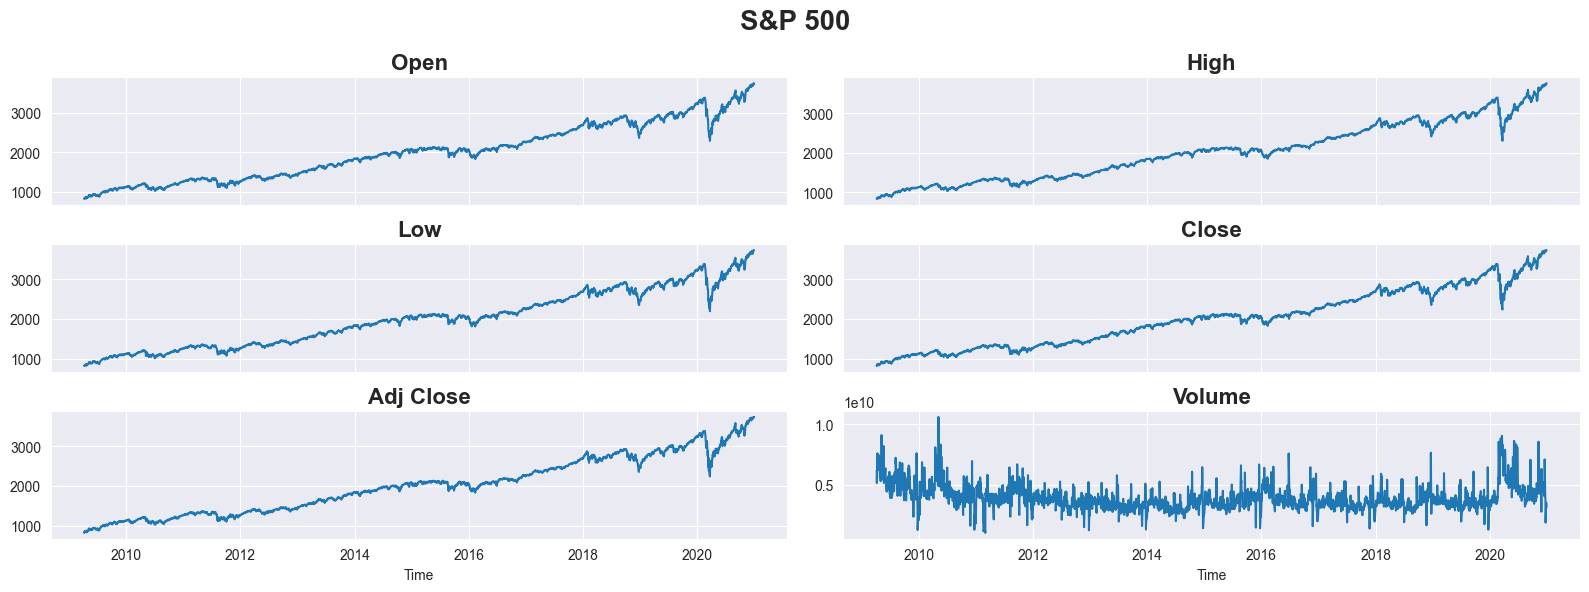

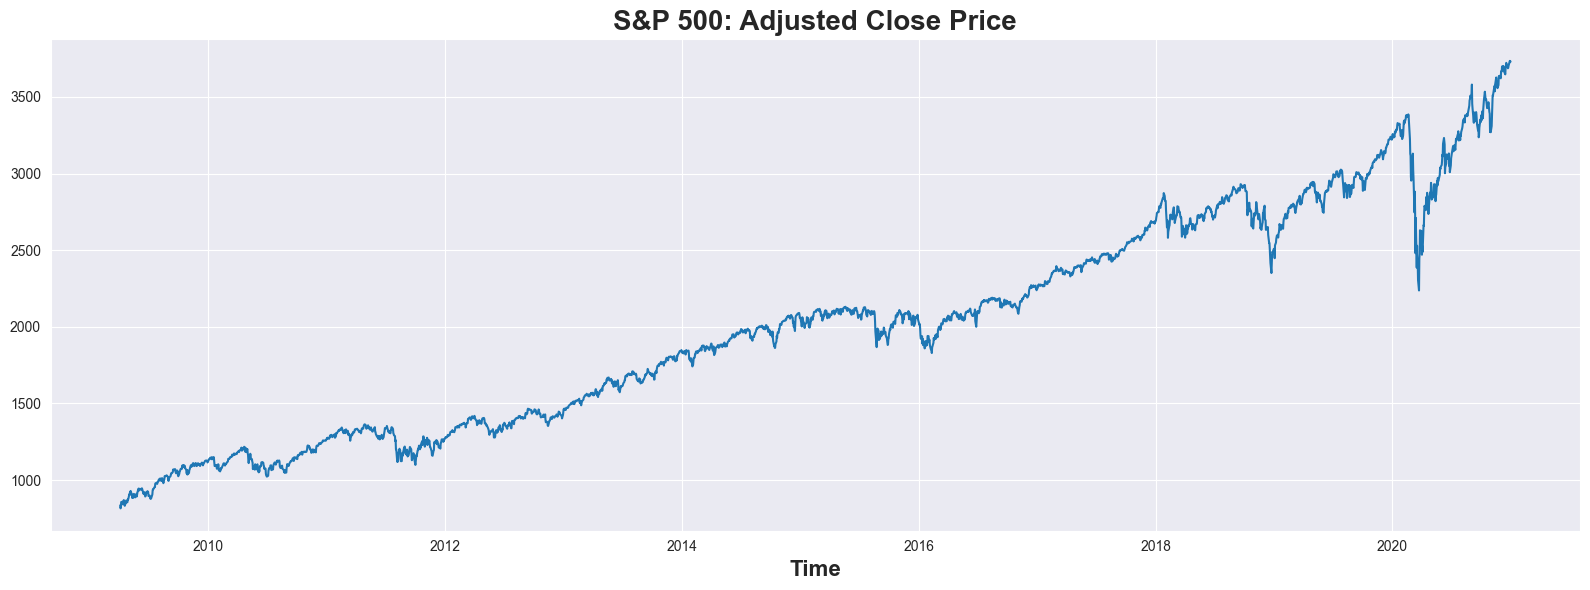

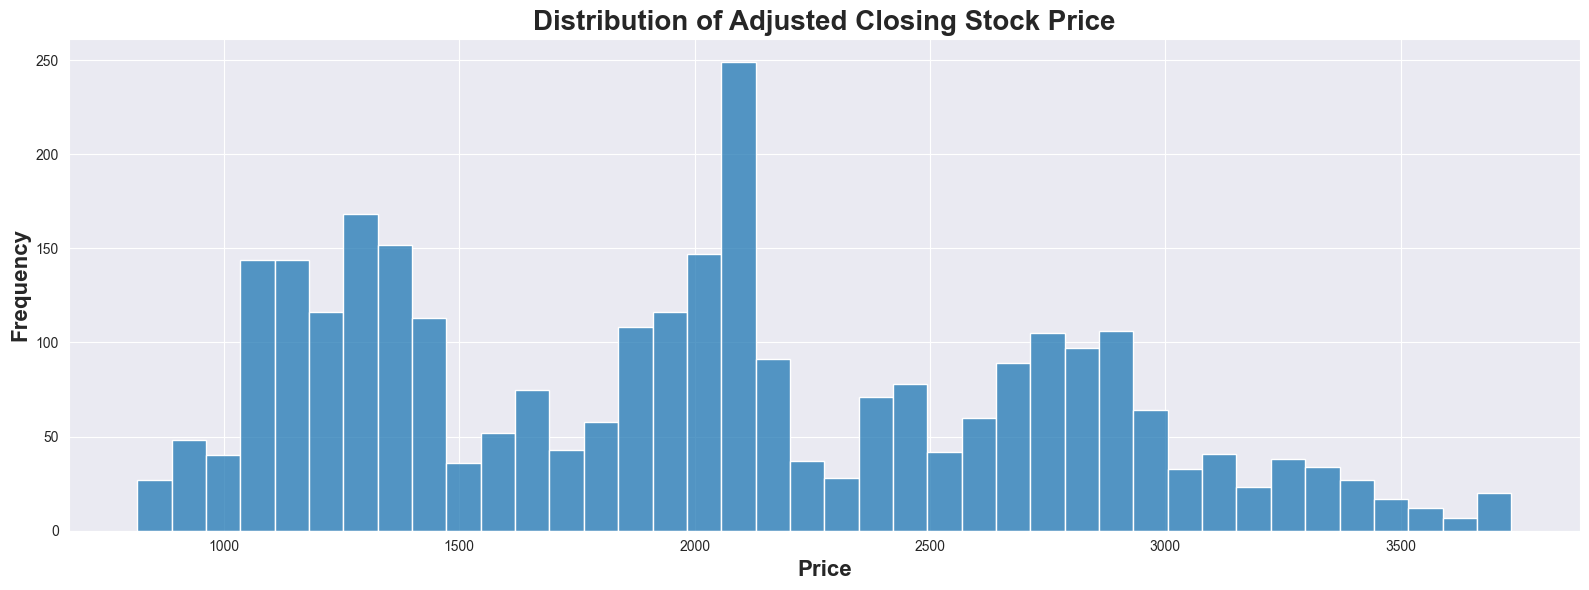

In [115]:
display(set_frame_style(raw_data.describe()))

fig, axes = plt.subplots(3,2, sharex=True)
axes = axes.flatten()
for i, col in enumerate(df.columns):
  sns.lineplot(data = df[col],
               ax = axes[i],
               legend = False)
  axes[i].set_ylabel(None)
  axes[i].set_xlabel('Time')
  axes[i].set_title(f'{col}',fontdict=fontdict(16))
fig.suptitle("S&P 500", fontsize=20, fontweight='bold') 
plt.tight_layout()
plt.show()

plt.plot(df['Adj Close'])
plt.title('S&P 500: Adjusted Close Price', fontdict=fontdict())
plt.xlabel('Time', fontdict=fontdict(16))
plt.ylabel(None)
plt.tight_layout()
plt.show()

sns.histplot(df['Adj Close'],bins=40)
plt.title('Distribution of Adjusted Closing Stock Price', fontdict=fontdict(20))
plt.xlabel('Price',fontdict=fontdict(16))
plt.ylabel('Frequency',fontdict=fontdict(16))
plt.tight_layout()
plt.show()

## **Data Exploration and Preprocessing**

**Reasons of using Returns instead of Prices to estimate volatility**:
Returns quantify the growth rate or change in the value of a financial asset over time. Since Return focuses on the price changes, returns-driven volatility estimation would lead to more accurate predictions of future market dynamics compared to the raw price. 

**Reasons of using Daily Logarithmic returns instead of Daily Simple Returns:** 
**Additive**: Log returns are additive over time periods. For example, if we want to calculate the returns over multiple periods, we can simply sum the individual log returns for each period. This makes it easy to evaluate the overall performance of a portfolio over a period of time
**Normal Distribution Assumption**: Log returns assume a continuos compounding process, leading to distributions that tend to closely resemble normal distributions, which aligns well with the assumption of normal distribution made in many financial modeling and analysis techniques.
**Logarithmic returns formula**:
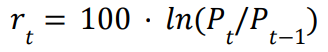

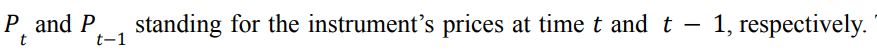

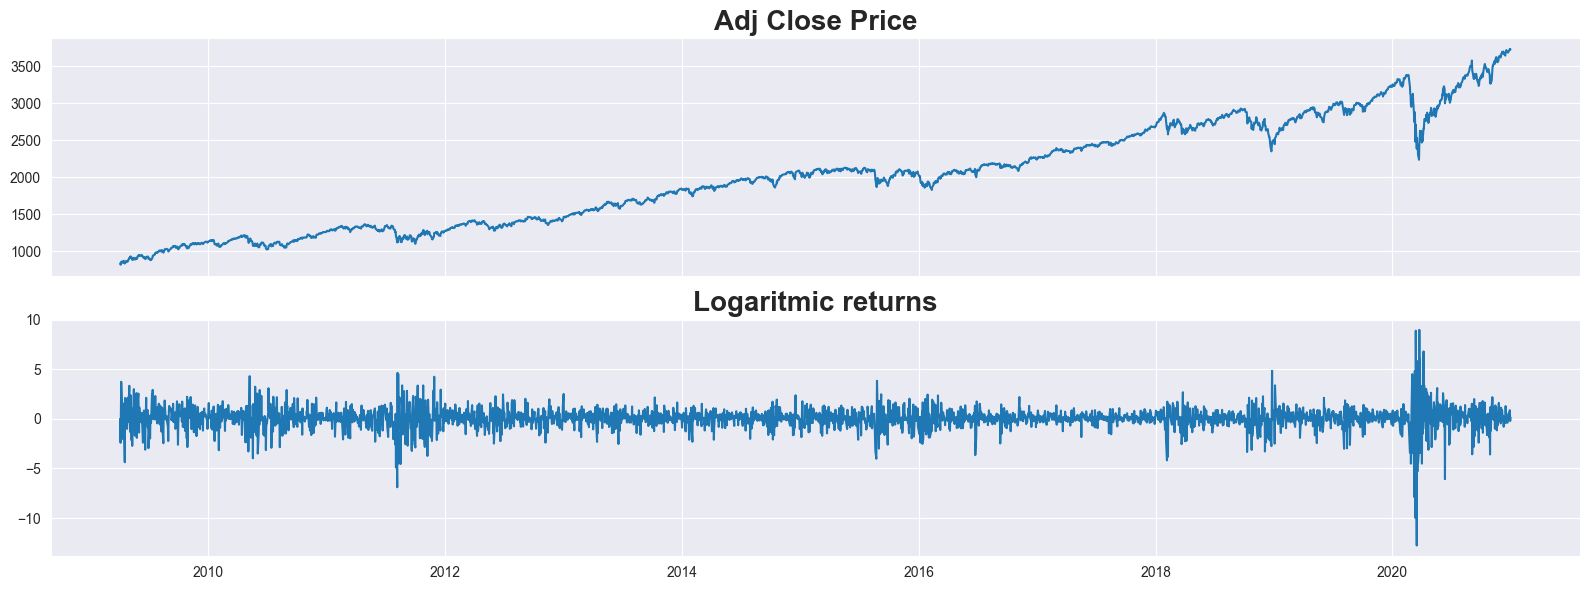

In [116]:
log_returns = 100*np.log(df['Adj Close']/df['Adj Close'].shift(1)).fillna(0)
df = df.dropna()

figure, axes = plt.subplots(2,1,sharex = True)
axes[0].plot(df['Adj Close'])
axes[0].set_title('Adj Close Price', fontdict=fontdict())

axes[1].plot(log_returns)
axes[1].set_title('Logaritmic returns', fontdict=fontdict())
plt.tight_layout()
 

Skewness: -0.8060802665984705
Kurtosis: 14.781647802006173


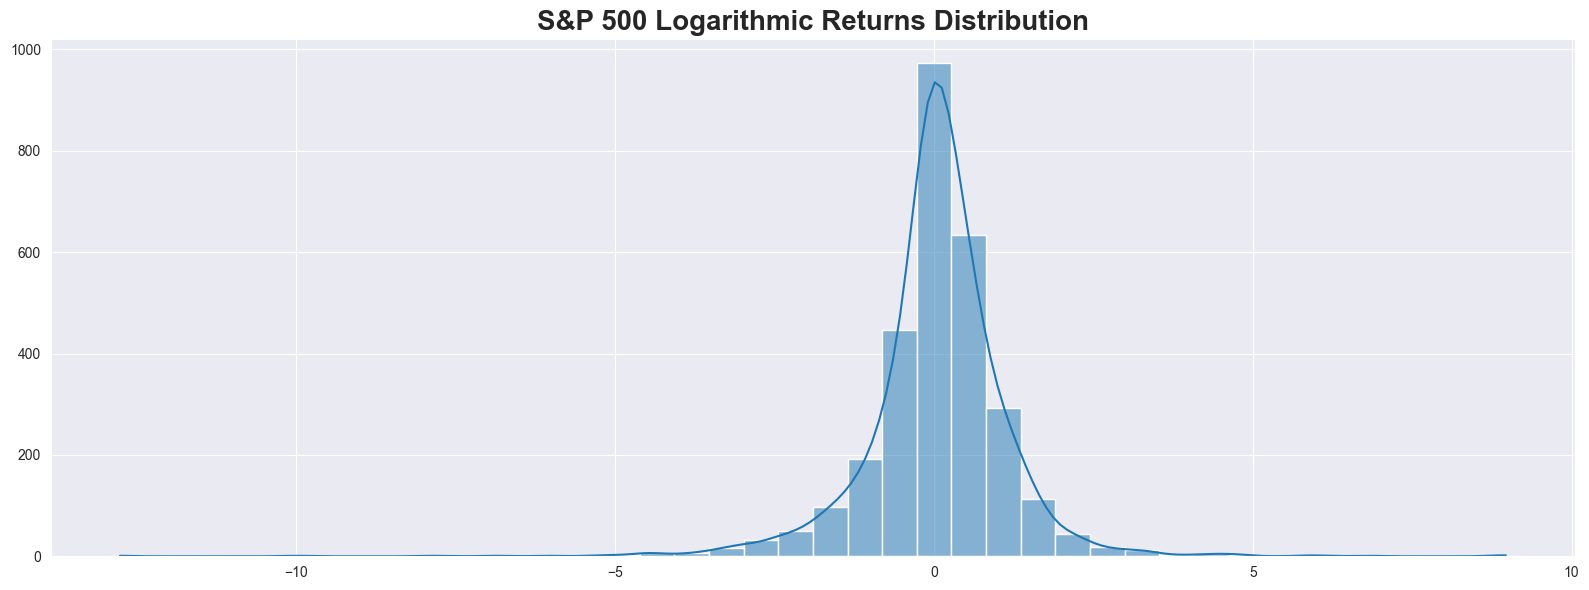

In [117]:
sns.histplot(log_returns,kde=True,bins=40)
plt.title('S&P 500 Logarithmic Returns Distribution', fontdict=fontdict())
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
print('Skewness:',scipy.stats.skew(log_returns,bias=True))
print('Kurtosis:',scipy.stats.kurtosis(log_returns,bias=True))


#Negative skewness suggests that the tail of the distribution is longer on the left side compared to the right side. This means that there are more extreme values on the lower end of the scale, which could indicate occasional small gains. However, it also implies the likelihood of a few significant losses. On the other hand, positive kurtosis, also known as leptokurtosis, indicates heavier tails and a more peaked distribution relative to a normal distribution. This means that extreme values, both positive and negative, are more likely to occur compared to what would be expected under a normal distribution. Overall, the data appears fairly symmetrical and normally distributed

### **Basic Outliers Detecting**
Given that the primary objective of this project is to construct a forecasting model for volatility, I won't delve extensively into anomaly detection. Certainly, there are many   better outlier detection techniques than the one I used below.

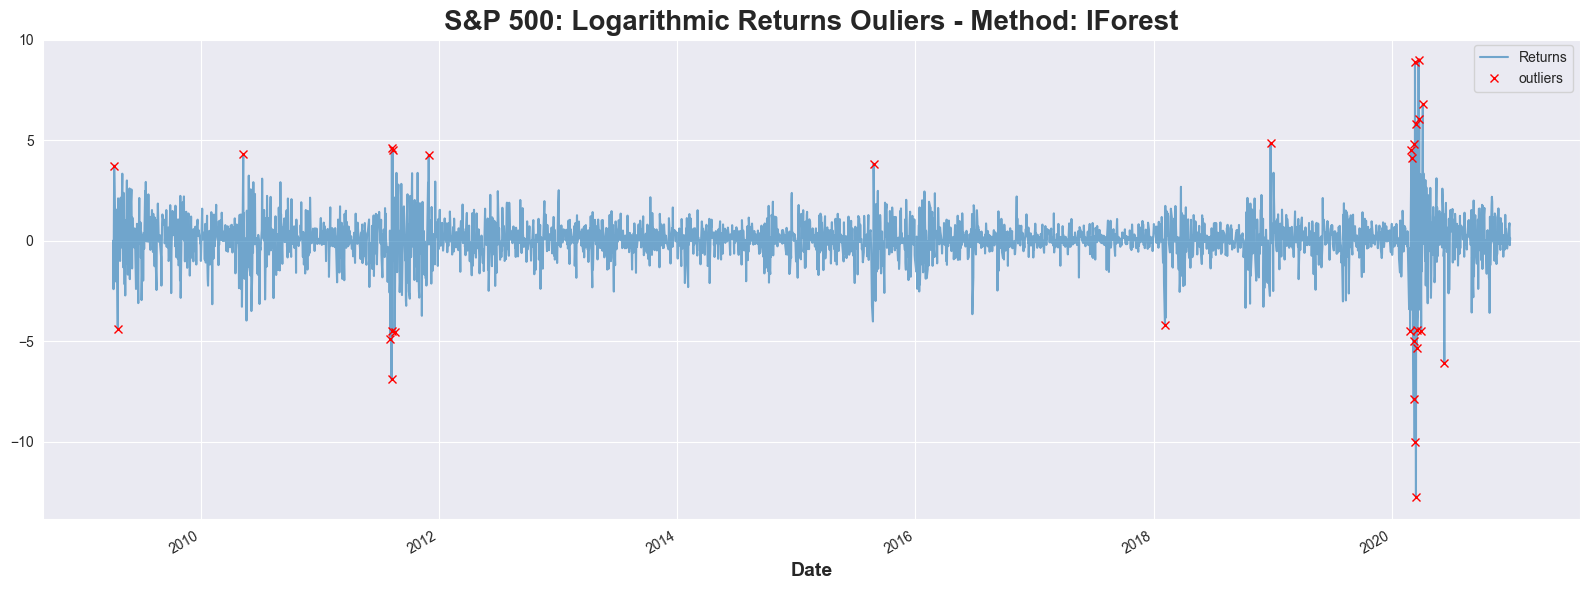

In [120]:
def plot_outliers(outliers, data, method, halignment = 'right',
                  valignment = 'bottom', labels = False):
  ax = data.plot(alpha = 0.6)
  if labels:
    for i in outliers['value'].items():
      plt.plot(i[0],i[1],'rx')
      plt.text(i[0],i[1],f'{i[0].date()}',
               horizontalalignment=halignment,
               verticalalignment= valignment)
  else:
    data.loc[outliers.index].plot(ax = ax,style ='rx')
  plt.title(f'S&P 500: Logarithmic Returns Ouliers - Method: {method}', fontdict=fontdict())

  plt.xlabel('Date',fontdict=fontdict(14))
  plt.legend(['Returns','outliers'], loc='best')
  plt.tight_layout()

iforest = IForest(contamination=0.01, n_estimators=100,random_state=0)
iforest.fit(pd.DataFrame(log_returns))
predicted = pd.Series(iforest.predict(pd.DataFrame(log_returns)), index=pd.DataFrame(log_returns).index)
outliers = predicted[predicted==1]
outliers = pd.DataFrame(log_returns).loc[outliers.index]
outliers.sum()
plot_outliers(outliers, log_returns,'IForest')

#### **Square returns**: 
- Square returns give us the general idea about volatility. High values of squared returns indicate higher volatility or risk in the underlying asset.  

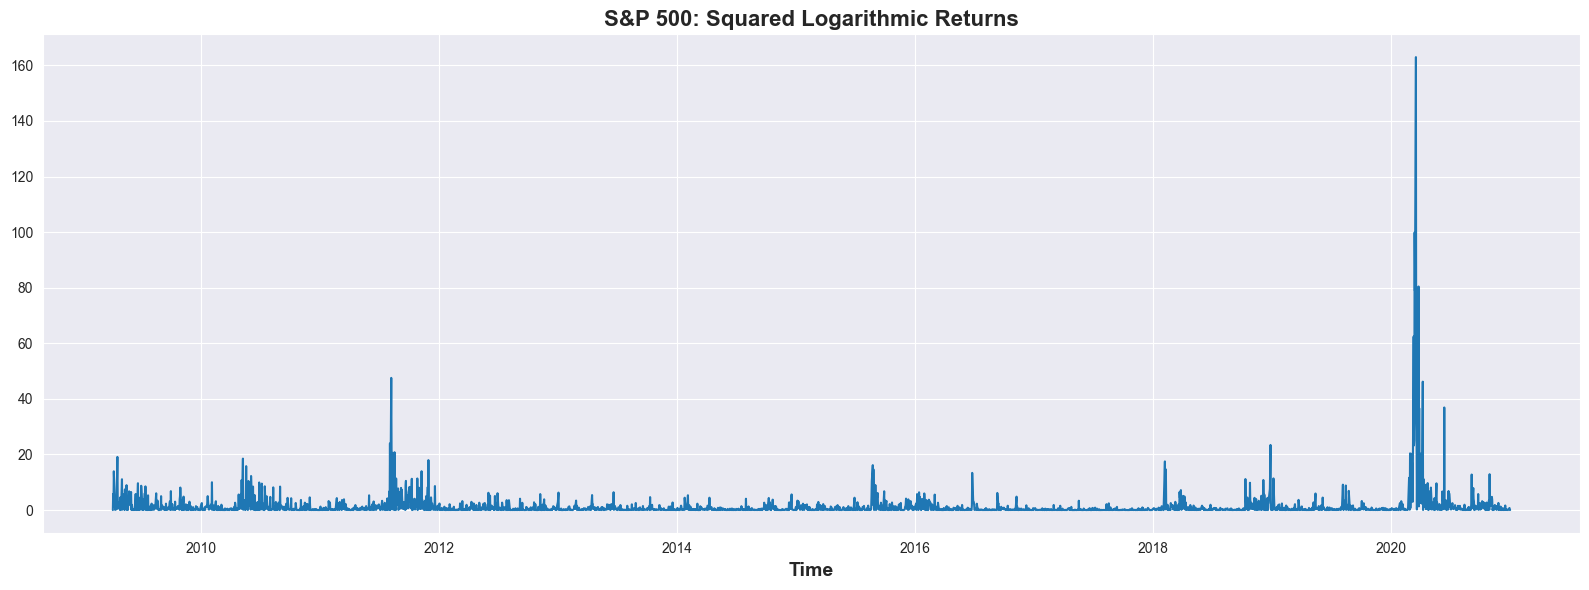

In [8]:
squared_log_returns = log_returns**2
plt.plot(squared_log_returns)
plt.title('S&P 500: Squared Logarithmic Returns', fontdict=fontdict())
plt.xlabel('Time', fontdict=fontdict(14))
plt.tight_layout()

#As depicted in the graph above, the returns exhibit significant volatility particularly in 2020 and 2012

### **Train, test split**

In [121]:
test_size = 365
train_size =  len(log_returns)-test_size
test_index = log_returns[-test_size:]
train_index = log_returns[:-test_size]
print('The size of the training data:',train_size)
print('The size of the testing data:', test_size)


The size of the training data: 2591
The size of the testing data: 365


### **Volatility Calculation**: 
#### **Different methods for computing volatility**:
- **Close-to-close**: assumes Returns are not related to past returns (zero autocorrelation between returns). It also has an assumption of Discrete time (fixed time intervals). However, this assumption is not always accurate. People rarely trade in fixed time intervals (for example,at close price only or at open price only).
    **Formula:** 
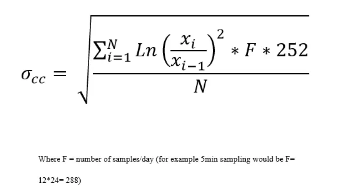

- ##### **Parkinson Volatility**: Instead of using closing price, it uses the high and low price, which makes it less sensitive to sample intervals. However, the estimator does not account for jumps (intraday/ close-open/ weekends)
###### **Formula:** 
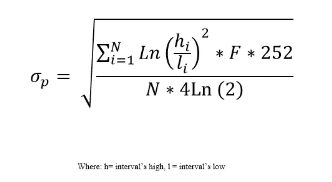
- ##### **Garman Klass Volatility**: This estimator is a better version of Parkinson Volatility which takes into account the intraday price dynamic by accounting for open/close price. However, it still does not address jumps, and tend to underestimates realized volatility
###### **Formula:** 
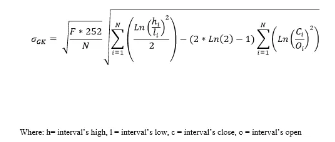
- ##### ***GKYZ Volatility***: This estimator can address most aspects of realized price dynamic and can handle intraday dynamic, as well as overnight jump. Hence, it is considered the most efficient estimator.
###### **Formula:** 
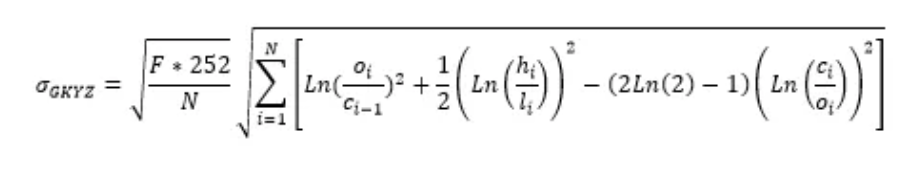
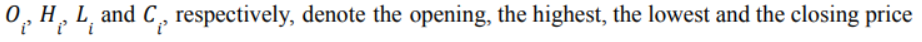
#### **The Size of Window**: The size of the window affects the overall  result. The wider the window, the less representative the measurement will become. As the window narrows,  It results in a more volatile moving average. So, it is a bit of an art to pick the proper window size based upon the data sampling frequency. 
#### I will choose n = 10
#### **Scale Volatility Estimator**:
#### We need to scale the Volatility estimator to match the magnitude of the volatility estimates with the ones produced from Garch model. Here is a formula proposed by Fiszeder (2005,2009):
###### **Formula:** 
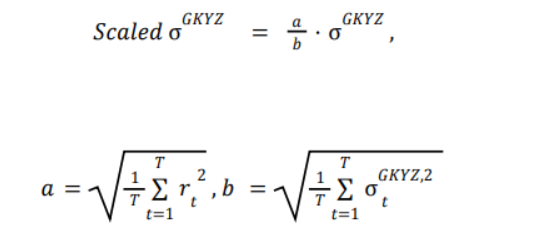

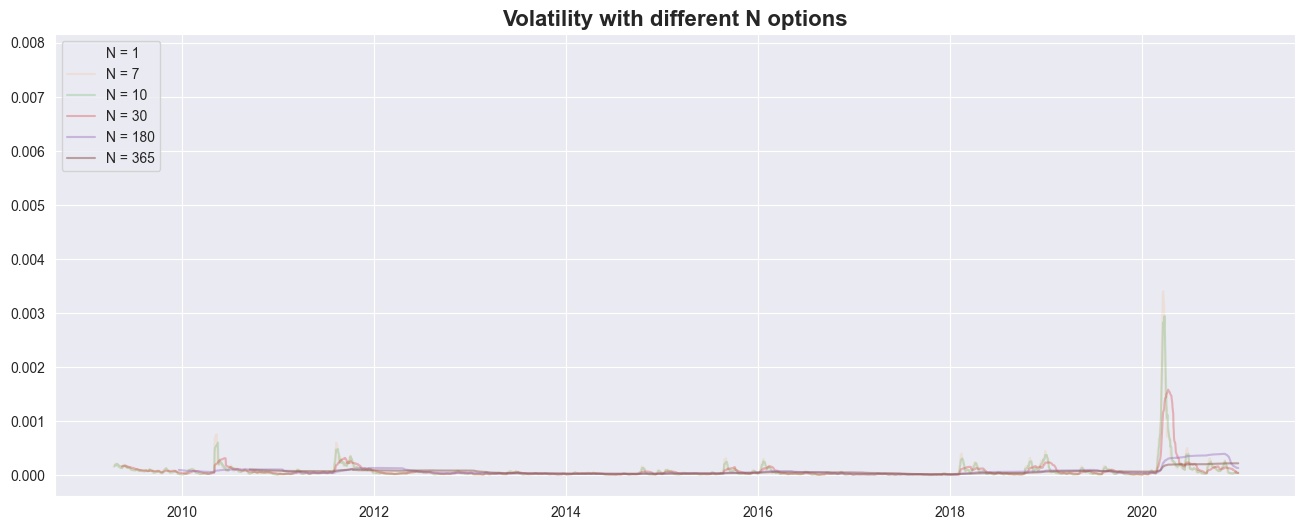

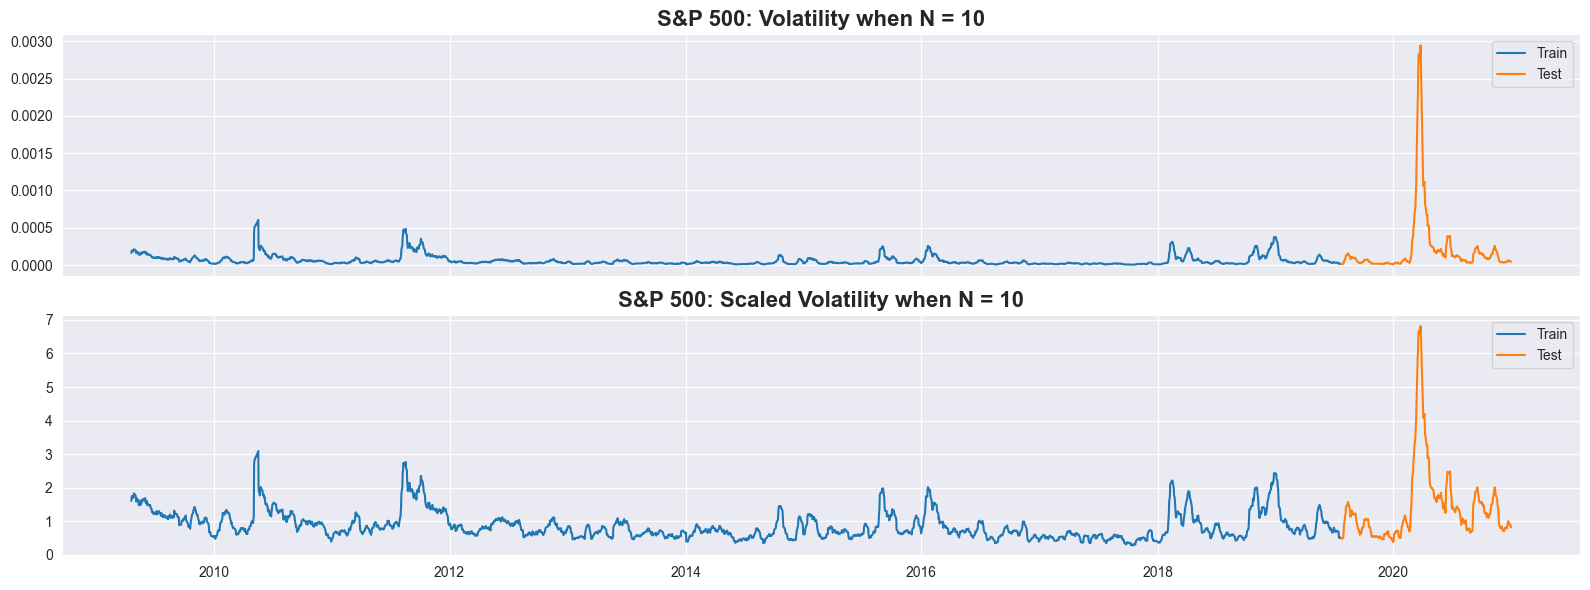

In [10]:
window_options = [1,7,10,30,180,365]

vol_df = pd.DataFrame()
for window in window_options:
  vol = ((np.log(df['Open']/(df['Close'].shift(1)))**2) + 1/2*(np.log(df['High']/df['Low'])**2) - (2*np.log(2)-1)*(np.log(df['Close']/df['Open'])**2)).rolling(window).mean()
  vol_df = pd.concat([vol_df, vol], axis=1,ignore_index=True)
vol_df.columns = [f'N = {x}' for x in window_options]

for i, column in enumerate(vol_df.columns):
  plt.plot(vol_df[column], label=column, alpha=i*0.1)
plt.title('Volatility with different N options', fontdict=fontdict())
plt.legend(loc='upper left')
plt.show()

vol_ts = vol_df['N = 10']
vol_ts = vol_ts.dropna()

a = np.sqrt(1/len(df)* sum(((log_returns)**2)))
b = np.sqrt(1/len(df)*sum(vol_ts))

scaled_vol = a/b * np.sqrt(vol_ts)

fig, axes = plt.subplots(2,1,sharex=True)

axes[0].plot(vol_ts[:-test_size])
axes[0].plot(vol_ts[-test_size:])
axes[0].legend(['Train', 'Test'])
axes[0].set_title('S&P 500: Volatility when N = 10', fontdict=fontdict())

axes[1].plot(scaled_vol[:-test_size])
axes[1].plot(scaled_vol[-test_size:])
axes[1].legend(['Train', 'Test'])
axes[1].set_title('S&P 500: Scaled Volatility when N = 10', fontdict=fontdict())

plt.tight_layout()

#### **Volatility forecasts evaluation**
##### Two standard forecast error metrics:
##### **MSE**:
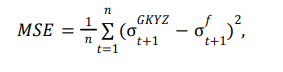
##### **MAE**:
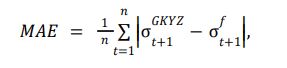
##### where  is the volatility estimated using the GKYZ estimator and 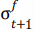 is the volatility forecast from a given model.

In [11]:
comparison_df = pd.DataFrame()
def concat_model(model, MSE, MAE, comparison_df=comparison_df):
  comparison_df = pd.concat([comparison_df, pd.DataFrame([[f'{model}',MSE,MAE]], columns=['Model','MSE','MAE'])], axis=0,ignore_index=True)
  return comparison_df

def compute_metrics(actual, predicted):
  return (mean_squared_error(actual, predicted),
          mean_absolute_error(actual, predicted))



### **Baseline models**
#### Establishing baseline models for time series data serves crucial purposes:
- ##### **Perfomance Benchmarking**: Baseline models provide a reference point against which the performance of more complex models can be compared.
- ##### **Evaluate Model Complexity**: Baseline models help in assessing whether the complexity introduced by advanced modeling techniques is justified. If a baseline model performs comparably to or even outperforms more complex models, it suggests that the additional complexity may not be necessary for capturing the essential characteristics ò the time series.

#### **Mean Forecasting**

,Model,MSE,MAE
0,Mean,1.716823,0.738683


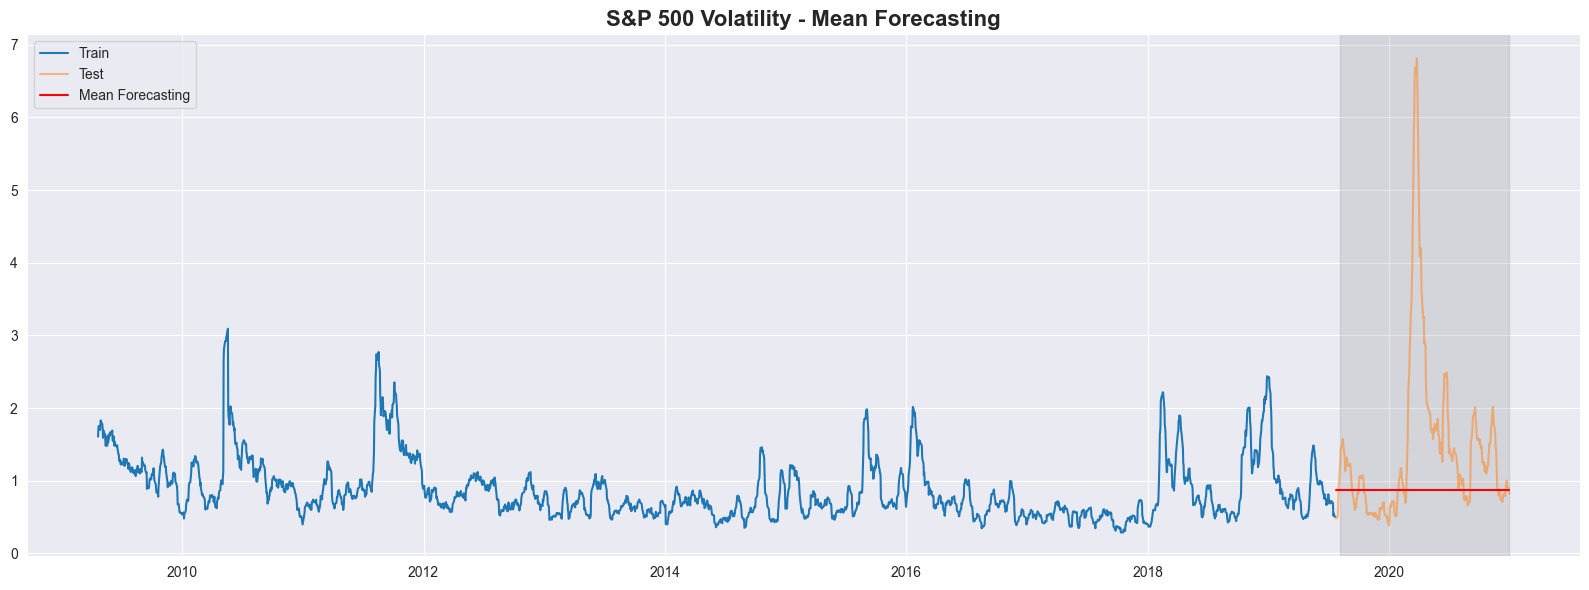

In [12]:
mean_train = np.mean(scaled_vol[:-test_size])
mean_pred = pd.Series(np.full(shape=test_size, fill_value=mean_train, dtype='float'),index=scaled_vol[-test_size:].index)

plt.plot(scaled_vol[:-test_size])
plt.plot(scaled_vol[-test_size:], alpha=0.5)
plt.plot(mean_pred, color='red')
plt.legend(['Train','Test', 'Mean Forecasting'])
plt.title('S&P 500 Volatility - Mean Forecasting', fontdict= fontdict())
plt.axvspan(scaled_vol.index[train_size], scaled_vol.index[-1], color='#808080', alpha=0.2)
plt.tight_layout()

MSE, MAE= compute_metrics(mean_pred[-test_size:], scaled_vol[-test_size:])
comparison_df=concat_model('Mean', MSE, MAE)
display(set_frame_style(comparison_df))



#### **Random Walk forecasting**
##### Below is the process of forecasting using a random walk for one unit of time ahead. The approach for forecasting ten units of time will generally follow a similar procedure
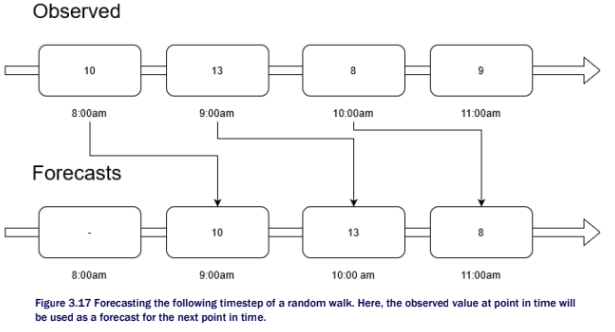


<function matplotlib.pyplot.show(close=None, block=None)>

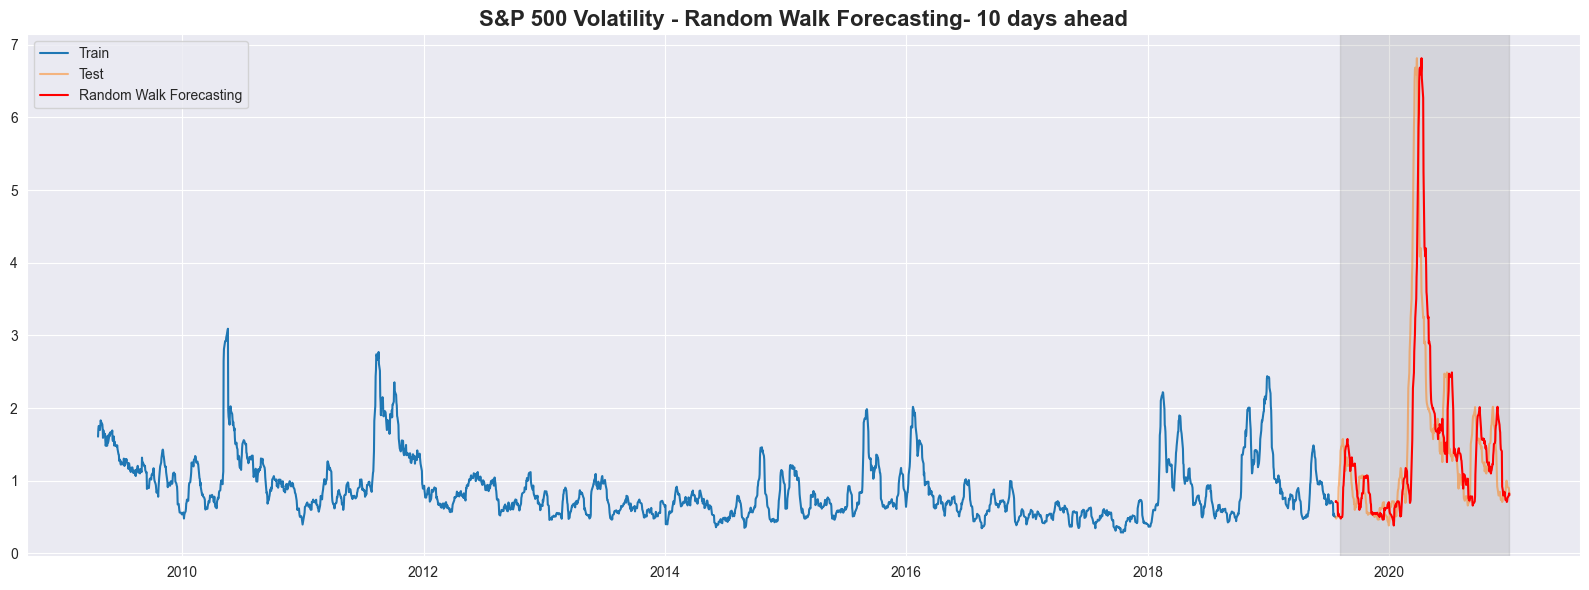

In [13]:
rw_pred = scaled_vol.shift(periods=10)
plt.plot(scaled_vol[:-test_size])
plt.plot(scaled_vol[-test_size:], alpha=0.5)
plt.plot(rw_pred[-test_size:], color='red')
plt.legend(['Train','Test', 'Random Walk Forecasting'])
plt.title('S&P 500 Volatility - Random Walk Forecasting- 10 days ahead', fontdict= fontdict())
plt.axvspan(scaled_vol.index[train_size], scaled_vol.index[-1], color='#808080', alpha=0.2)
plt.tight_layout()
plt.show

,Model,MSE,MAE
0,Naive Forecasting,0.841333,0.571458


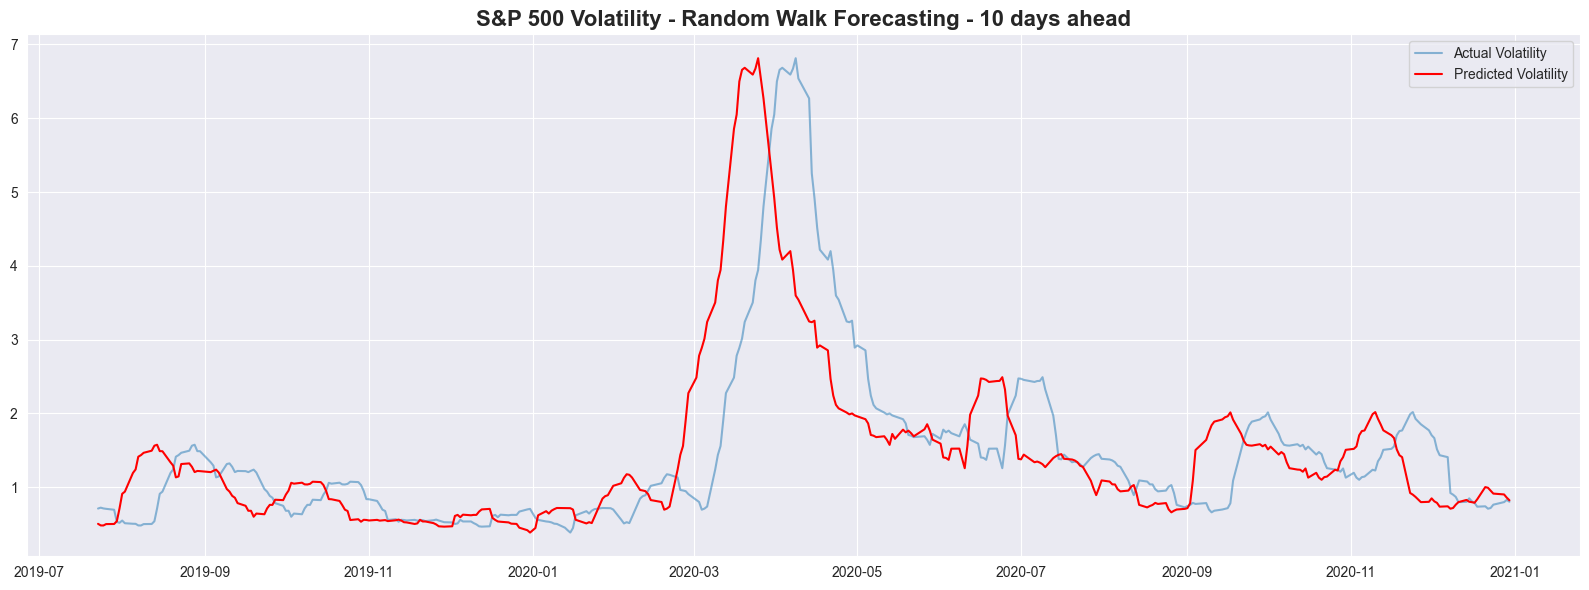

In [14]:

plt.plot(rw_pred[-test_size:], alpha=0.5)
plt.plot(scaled_vol[-test_size:], color='red')
plt.legend(['Actual Volatility', 'Predicted Volatility'])
plt.title('S&P 500 Volatility - Random Walk Forecasting - 10 days ahead', fontdict= fontdict() )
plt.tight_layout()

MSE, MAE= compute_metrics(rw_pred[-test_size:], scaled_vol[-test_size:])
comparison_df=concat_model('Naive Forecasting', MSE, MAE)
display(set_frame_style(comparison_df))

### **GARCH models**
##### The GARCH model, which stands for Generalized Autoregressive Conditional Heteroskedasticity.
- #### *Autoregressive*: means that the current value of a variable is influenced by past values of itself at different periods 
- #### *Heteroskedasticity*: means that the model may have different magnitudes or variability at different time points (variance changes over time).
- #### *Conditional*: since the volatility is not fixed, the reference here is on the constant that we place in the model to limit heteroskedasticity and make it conditionally dependent on the previous value or values of the variable.

##### **Model**: GARCH (p, q) can be written as follows:
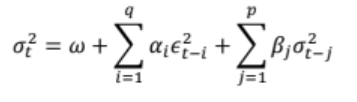
##### Omega, alpha, beta  are paremeters. 
##### q: the number of past (lag) squared residual errors 
##### p: the number of past variances 
##### For example, GARCH (1,1) can be written as follows:
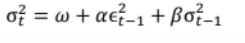

##### We can identify the GARCH process by looking at the ACF and PACF of the squared returns. An ARMA type look (the gradual decay in autocorrelation and significant spikes in the pacf) suggests GARCH process. 

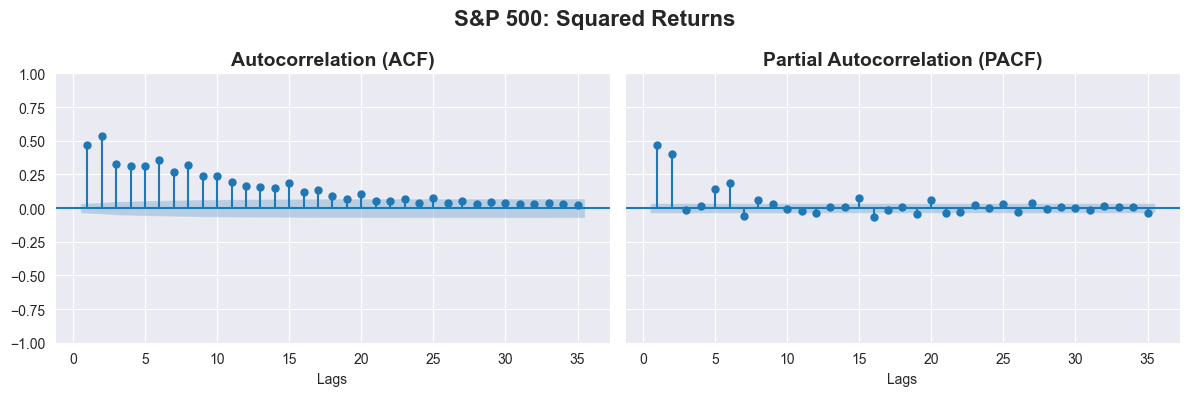

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize =(12,4))

plot_acf(log_returns**2, zero=False, ax=ax1)
plot_pacf(log_returns**2, zero=False, ax=ax2)
fig.suptitle('S&P 500: Squared Returns', fontsize=16, fontweight='bold')
ax1.set_xlabel('Lags')
ax1.set_title('Autocorrelation (ACF)', fontdict = fontdict(14))
ax2.set_title('Partial Autocorrelation (PACF)', fontdict = fontdict(14))
ax2.set_xlabel('Lags')
plt.tight_layout()

##### #we see the spikes at 1,2 ,7, ..from pacf, so the degree will fall into such values, we can do the grid search to find the best one.

#### Now, let's implement the grid search, and compare different models with varying degrees, and look for the one that has the lowest AIC score and number of insificicant parameters . 
##### **AIC Score**: (Akaike's Information Criterion), defined as: 
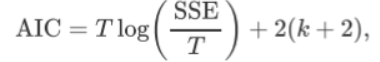
##### ***T*** is the number of observations used for estimation and k is the number of predictors in the model
- ##### The idea is to penalize the fit of the model (SSE - sum of squared errors) with the number of parameters that need to be estimated.
- ##### The model with the minimum value of the AIC is often the best model for forecasting. 
##### **Insignificant parameters**: are those with p-values greater than the predetermined significance level (typically set at 0.05). These values can be observed in the **P|t|** column of Table 2 of the '.summary()' output. Evaluating this metric allows us to determine the number of parameters that are not significantly different from 0. Generally, a smaller value indicates a better model fit.
#### *I will prioritize the later metrics when sorting the performance of different models.
#### For this grid search, The parameters can be broken down into three main components based on the model's assumptions: a distribution that's controlled by the *dist* parameter that defaults to 'normal', a mean model that's controlled by the *mean* parameter that defaults to 'Constant', and a volatility process that's controlled by the *vol* parameter that defaults to 'GARCH'

In [16]:
best_aic = float('inf')
best_order = None
models_df = pd.DataFrame()
for p in range(1,7):  
    for q in range(1,7):
        model = arch_model(log_returns, 
                           vol='Garch',
                           mean ='constant',
                           dist = 'normal',
                            p=p, q=q)
        result = model.fit(disp='off')
        aic = result.aic

        if aic < best_aic:
            best_aic = aic
            best_order = (p, q)

        coef_table_df=pd.DataFrame(result.summary().tables[2])
        coef_table_cols = [str(cell) for cell in coef_table_df.loc[0].values]
        coef_table_df.columns=coef_table_cols
        coef_table_df = coef_table_df[1:]
        coef_table_df['P>|t|'] = coef_table_df['P>|t|'].astype(str).astype(float)
        count_significant_coeff = (coef_table_df['P>|t|']> 0.05).sum()
        models_df = pd.concat([models_df, pd.DataFrame({'(p,q)':[(p,q)],'AIC':[(aic)],'Number of Insignificant Coefficients':[count_significant_coeff]})],ignore_index=True)
            
models_df.sort_values(by=['Number of Insignificant Coefficients','AIC'],ignore_index=True).head(5)

,"(p,q)",AIC,Number of Insignificant Coefficients
0,"(1, 1)",7.552e+03,0
1,"(2, 2)",7.547e+03,1
2,"(2, 1)",7.548e+03,1
3,"(1, 2)",7.554e+03,1
4,"(3, 2)",7.549e+03,2


##### #As shown in the table, (p,q) = (1,1) is the best one with the least number of insignificant coefficient and lowest AIC. Therefore, I will stick with this order when building the GARCH model.

### **Choices of Distributions**
Financial returns are often heavy tailed, and a Students' T Distribution is one of the methods to capture this feature. Let's try different distribution (normal, students'T distribution and skew students'T distribution) with the order is (1,1), mean = 'Constant', and see their corresponding metrics.
For this, we want to compare the *AIC score* and *Log-Likelihood*. (Log-Likelihood assess the goodness of fit of the model to the data. A higher log likelihood indicates a better fit).

In [17]:
dists = ['normal','studentst', 'skewstudent']
for i,dist in enumerate(dists):
  model = arch_model(log_returns,dist=dist, vol = 'Garch', p=1, q=1, mean='Constant')
  result = model.fit(disp='off')
  table_summary = pd.DataFrame(result.summary().tables[0],columns=['Col_1', 'Value_1','Col_2','Value_2'])
  display(set_frame_style(table_summary,  f'Summary for {dist} distribution'))

,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3772.02
3,Distribution:,Normal,AIC:,7552.03
4,Method:,Maximum Likelihood,BIC:,7576.00
5,,,No. Observations:,2956
6,Date:,"Sat, Mar 16 2024",Df Residuals:,2955
7,Time:,12:48:42,Df Model:,1


,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3670.82
3,Distribution:,Standardized Student's t,AIC:,7351.64
4,Method:,Maximum Likelihood,BIC:,7381.59
5,,,No. Observations:,2956
6,Date:,"Sat, Mar 16 2024",Df Residuals:,2955
7,Time:,12:48:42,Df Model:,1


,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3659.38
3,Distribution:,Standardized Skew Student's t,AIC:,7330.76
4,Method:,Maximum Likelihood,BIC:,7366.71
5,,,No. Observations:,2956
6,Date:,"Sat, Mar 16 2024",Df Residuals:,2955
7,Time:,12:48:43,Df Model:,1


##### #Skewed Student Distribution is the best one with the lowest AIC and highest log-likelihood.

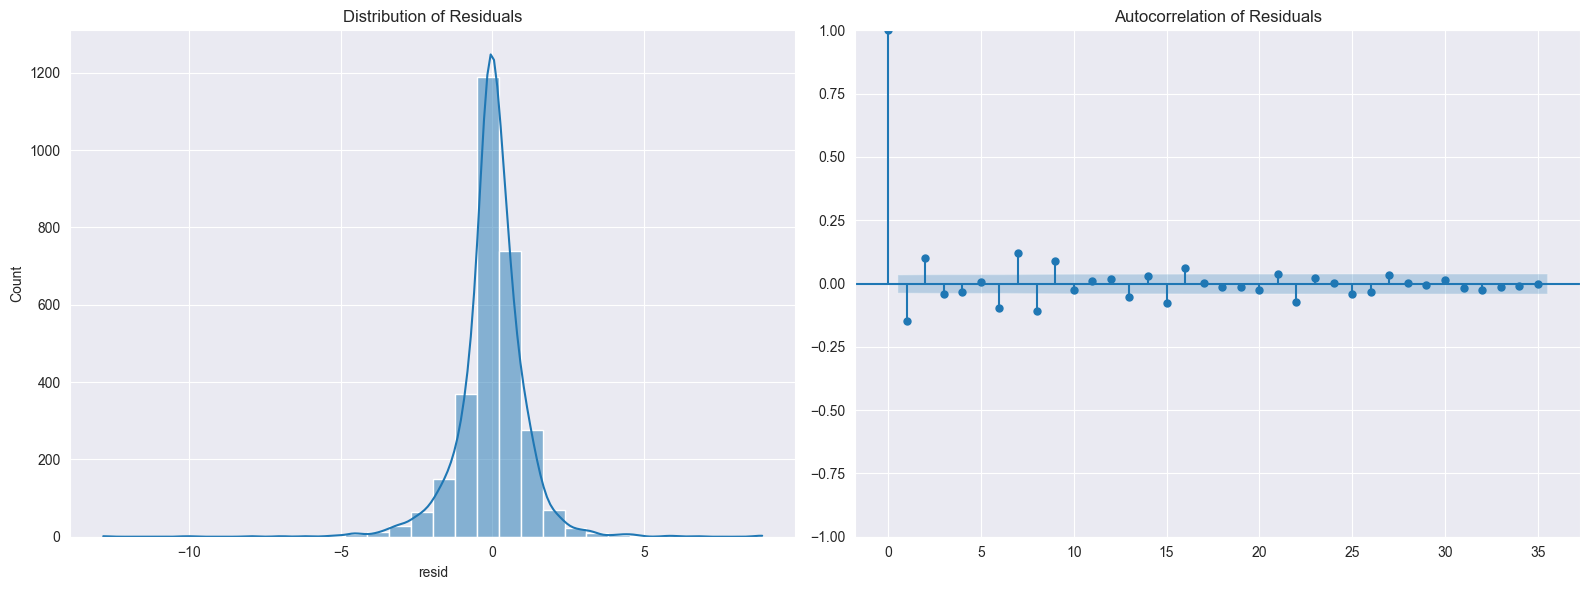

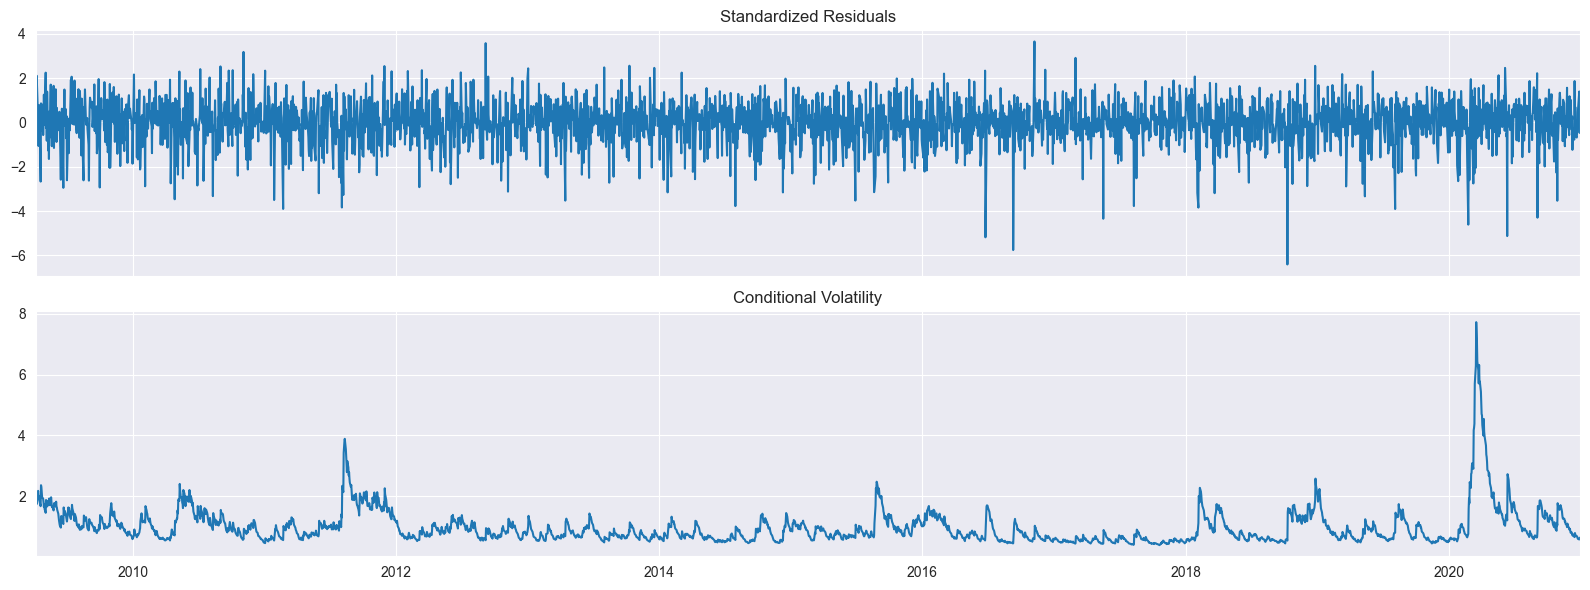

In [18]:
model = arch_model(log_returns,dist='skewstudent', vol = 'Garch', p=1, q=1)

result = model.fit(disp='off')
resid = result.resid 

figure, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(resid, ax = ax1, kde=True, bins = 30)
plot_acf(resid,ax = ax2)

ax1.set_title('Distribution of Residuals')
ax2.set_title('Autocorrelation of Residuals')
plt.tight_layout()
plt.show()

result.plot()
plt.tight_layout()
plt.show()



##### #The residuals has constant mean. The Conditional Volatility is also shown above

#### **Rolling Forecast**
#### I want to create a for loop that iteratively adjusts the training and testing datasets. Each training dataset will consist of 2591 data points, and each testing dataset will project 365 days ahead.
##### I will set the horizon to be equal 10.

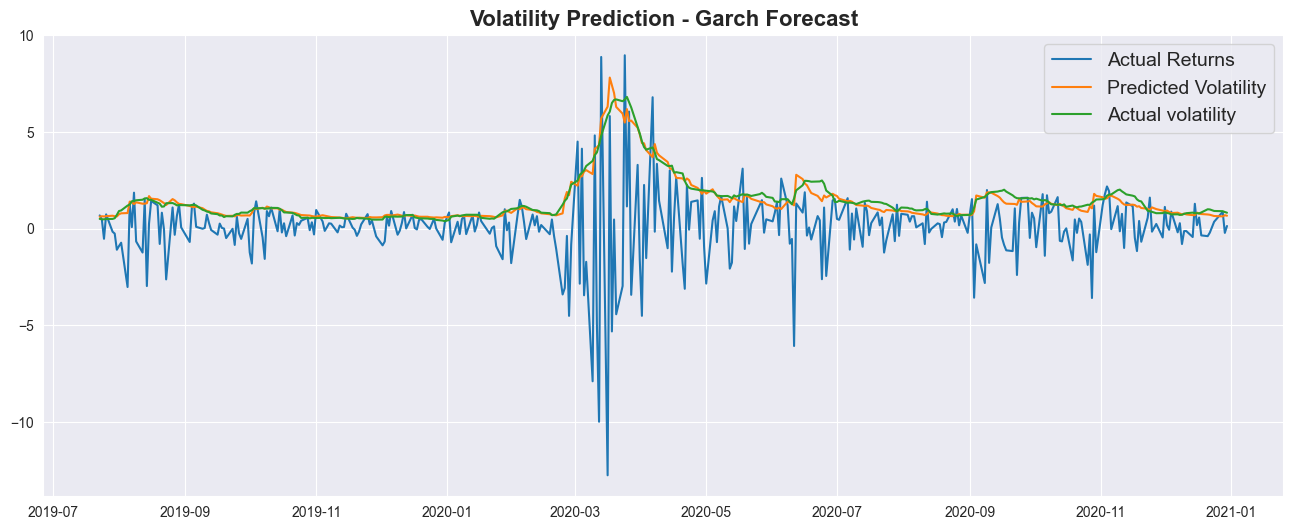

In [19]:
rolling_predictions = []
for i in range(test_size):
    train = (log_returns)[i:-(test_size-i)]
    model = arch_model(train, vol='GARCH', dist='skewstudent', p=1, q=1)
    model_fit = model.fit(disp='off')
    var = model_fit.forecast(horizon=10, reindex=False).variance.values
    pred = np.sqrt(np.mean(var))
    rolling_predictions.append(pred)
rolling_predictions = pd.Series(rolling_predictions, index = log_returns[-test_size:].index)

plt.plot(log_returns[-test_size:])
plt.plot(rolling_predictions)
plt.plot(scaled_vol[-365:])
plt.title('Volatility Prediction - Garch Forecast', fontdict = fontdict())
plt.legend(['Actual Returns', 'Predicted Volatility', 'Actual volatility'], fontsize=14)
plt.show()


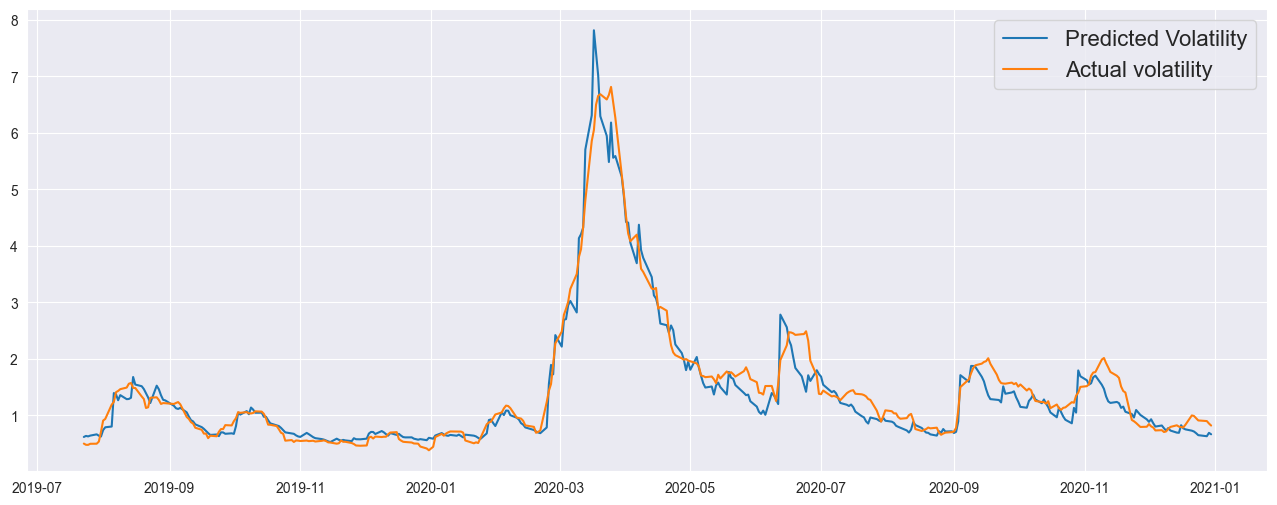

In [20]:
plt.plot(rolling_predictions)
plt.plot(scaled_vol[-test_size:])
plt.legend(['Predicted Volatility','Actual volatility'], fontsize=16)
plt.show()


In [23]:
MSE, MAE= compute_metrics(rolling_predictions, scaled_vol[-test_size:])
comparison_df = concat_model('Garch (Constant Mean, Skew Students Distribution)',MSE, MAE, comparison_df=comparison_df)
comparison_df

,Model,MSE,MAE
0,Naive Forecasting,0.8413,0.5715
1,"Garch (Constant Mean, Skew Students Distribution)",0.07454,0.1816


Let's Try other variants of GARCH model.

### **GJR-GARCH**
- The GARCH-GJR (Generalized Autoregressive Conditional Heteroskedasticity) model, also known as the GJR-GARCH model, is an extension of the standard GARCH model that incorporates an additional asymmetric term to capture the leverage effect. 
- The leverage effect refers to the phenomenon where negative shocks (returns below the mean) have a larger impact on future volatility than positive shocks of equal magnitude. The GJR-GARCH model allows for this asymmetry by introducing additional parameter that captures the effect of negative returns (returns below the mean) on volatility
- GJR-GARCH (1,1) model is represented as follows:

- where  when  and  otherwise.

In [34]:
model = arch_model(log_returns,
                   vol='GARCH', dist='skewstudent',
                    p=1, o=1, q=1)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -3599.06
Distribution:      Standardized Skew Student's t   AIC:                           7212.11
Method:                       Maximum Likelihood   BIC:                           7254.05
                                                   No. Observations:                 2956
Date:                           Sat, Mar 16 2024   Df Residuals:                     2955
Time:                                   15:17:03   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0368  1.282e-02      2.870  4.108e-03 [1.166e-02,6.192e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0283  5.078e-03      5.568  2.576e-08  [1.832e-02,3.822e-02]
alpha[1]   4.1290e-11  1.405e-02  2.939e-09      1.000 [-2.754e-02,2.754e-02]
gamma[1]       0.3025  4.271e-02      7.082  1.425e-12      [  0.219,  0.386]
beta[1]        0.8325  1.891e-02     44.021      0.000      [  0.795,  0.870]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            5.7219      0.619      9.241  2.451e-20 [  4.508,  6.936]
lambda        -0.1583  2.434e-02     -6.504  7.828e-11 [ -0.206, -0.111]
========================================================================

Covariance estimator: robust
"""

#There is a coefficient (alpha[1]) that is not statistically significant (**P>|t|** = 1). Therefore, we can expect that the performance of GJR-GARCH is not as effective as the previous GARCH model. We can test the idea by fitting the model with the same procedure as the previous model and compute the metrics to compare the performance of the two models.

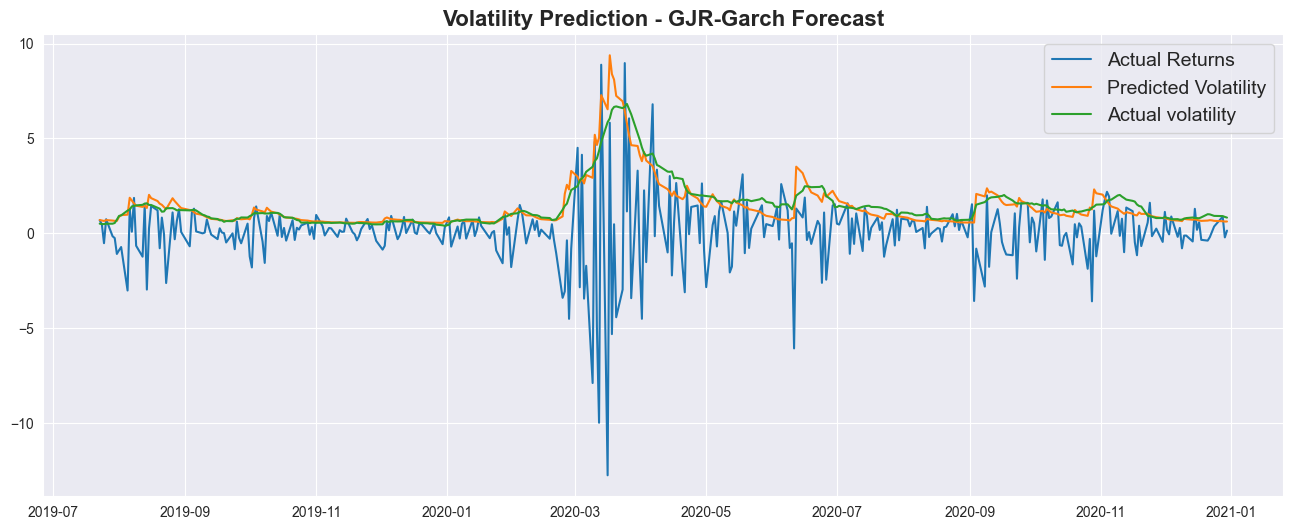

,Model,MSE,MAE
0,Naive Forecasting,0.8413,0.5715
1,"Garch (Constant Mean, Skew Students Distribution)",0.07454,0.1816
2,GJR-GARCH model,0.2117,0.2868
3,GJR-GARCH model,0.2117,0.2868
4,EGARCH model,0.4589,0.3559
5,GJR-GARCH model,0.196,0.2881
6,GJR-GARCH model,0.2117,0.2868


In [36]:
rolling_predictions = []
for i in range(test_size):
    train = (log_returns)[i:-(test_size-i)]
    model = arch_model(train, vol='GARCH', dist='skewstudent', p=1,o=1, q=1)
    model_fit = model.fit(disp='off')
    var = model_fit.forecast(horizon=10, reindex=False).variance.values
    pred = np.sqrt(np.mean(var))
    rolling_predictions.append(pred)
rolling_predictions = pd.Series(rolling_predictions, index = log_returns[-test_size:].index)

plt.plot(log_returns[-test_size:])
plt.plot(rolling_predictions)
plt.plot(scaled_vol[-test_size:])
plt.title('Volatility Prediction - GJR-Garch Forecast', fontdict = fontdict())
plt.legend(['Actual Returns', 'Predicted Volatility', 'Actual volatility'], fontsize=14)
plt.show()

MSE, MAE = compute_metrics(rolling_predictions, scaled_vol[-test_size:])
comparison_df = concat_model('GJR-GARCH model', MSE,MAE,comparison_df)
comparison_df

#As I expected, the model performance of GARCH-GJR is worse that that of the GARCH model. 

### **EGARCH**
EGARCH, or Exponential GARCH, is a type of generalized autoregressive conditional heteroskedasticity (GARCH) model that ,like GJR, also captures asymmetric volatility in fincancial time series data. EGARCH models also allows the volatility of returns to respond differently to positive and negative shocks. However, in an EGARCH model, the conditional variance equation is specified in terms of the natural logarithm of the conditional variance. The model is expressed as: 
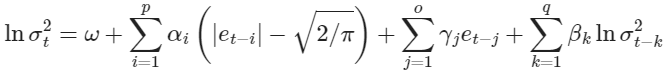
where 

In [37]:
model = arch_model(log_returns, p=1, o=1, q=1, 
                   vol='EGARCH', 
                   dist='skewstudent')
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -3590.78
Distribution:      Standardized Skew Student's t   AIC:                           7195.56
Method:                       Maximum Likelihood   BIC:                           7237.50
                                                   No. Observations:                 2956
Date:                           Sat, Mar 16 2024   Df Residuals:                     2955
Time:                                   15:19:23   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0312  1.281e-02      2.434  1.493e-02 [6.071e-03,5.627e-02]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega      -3.2676e-04  6.286e-03 -5.199e-02      0.959 [-1.265e-02,1.199e-02]
alpha[1]        0.1948  2.215e-02      8.792  1.472e-18      [  0.151,  0.238]
gamma[1]       -0.1969  1.778e-02    -11.072  1.709e-28      [ -0.232, -0.162]
beta[1]         0.9643  6.576e-03    146.639      0.000      [  0.951,  0.977]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            5.8687      0.654      8.968  3.030e-19 [  4.586,  7.151]
lambda        -0.1640  2.425e-02     -6.764  1.339e-11 [ -0.212, -0.117]
========================================================================

Covariance estimator: robust
"""

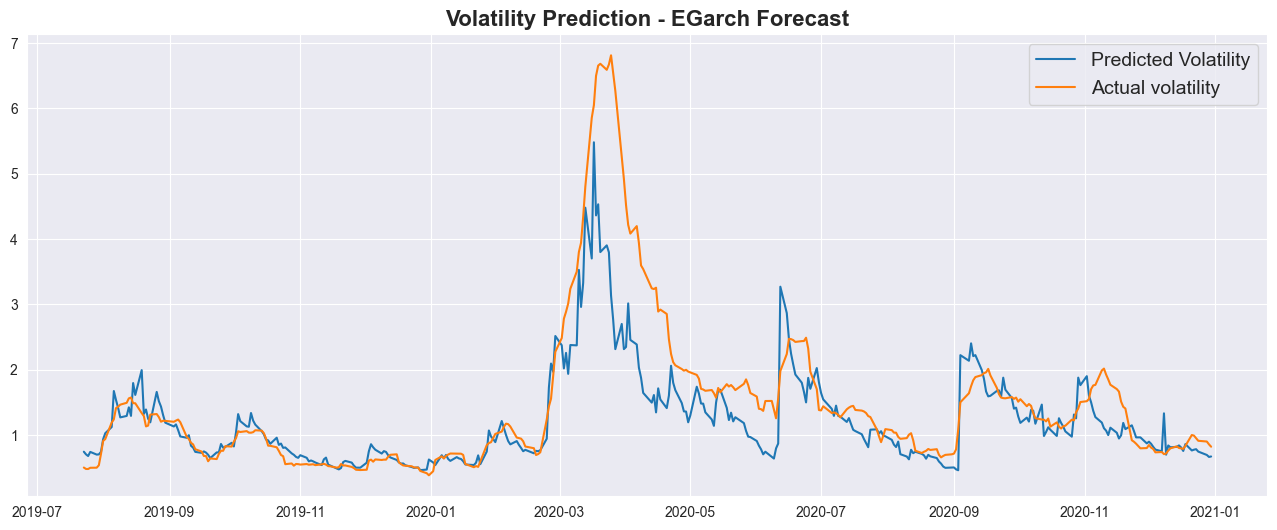

,Model,MSE,MAE
0,Naive Forecasting,0.8413,0.5715
1,"Garch (Constant Mean, Skew Students Distribution)",0.07454,0.1816
2,GJR-GARCH model,0.2117,0.2868
3,GJR-GARCH model,0.2117,0.2868
4,EGARCH model,0.4589,0.3559
5,GJR-GARCH model,0.196,0.2881
6,GJR-GARCH model,0.2117,0.2868
7,EGARCH model,0.458,0.3573
8,EGARCH model,0.5413,0.3828
9,EGARCH model,0.5037,0.3627


In [43]:
rolling_predictions = []
for i in range(test_size):
    train = (log_returns)[i:-(test_size-i)]
    model = arch_model(train, vol='EGARCH', dist='skewstudent', p=1,o=1, q=1)
    model_fit = model.fit(disp='off')
    var = model_fit.forecast(horizon=10,method='simulation' ,reindex=False).variance.values
    pred = np.sqrt(np.mean(var))
    rolling_predictions.append(pred)
rolling_predictions = pd.Series(rolling_predictions, index = log_returns[-test_size:].index)

plt.plot(rolling_predictions)
plt.plot(scaled_vol[-test_size:])

plt.title('Volatility Prediction - EGarch Forecast', fontdict = fontdict())
plt.legend(['Predicted Volatility', 'Actual volatility'], fontsize=14)
plt.show()
MSE, MAE = compute_metrics(rolling_predictions, scaled_vol[-test_size:])
comparison_df = concat_model('EGARCH model', MSE,MAE,comparison_df)
comparison_df

### APARCH
The idea is the same as EGARCH and GARCH-GJR models, which also introduces an additional parameter to capture the assymmetry in the impact of positive and negative shocks on volatility. In the APARCH model, however, asymmetry is captured by raising past returns to a power, allowing for a more flexible representation of asymmetry.
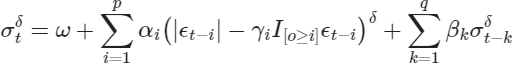


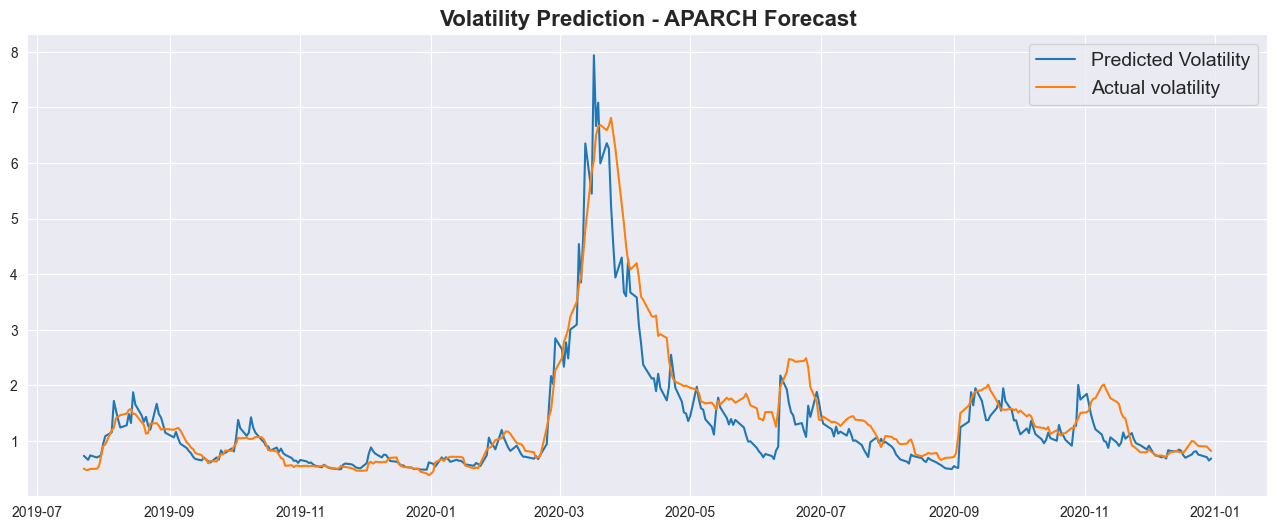

,Model,MSE,MAE
0,Naive Forecasting,0.8413,0.5715
1,"Garch (Constant Mean, Skew Students Distribution)",0.07454,0.1816
2,GJR-GARCH model,0.2117,0.2868
3,GJR-GARCH model,0.2117,0.2868
4,EGARCH model,0.4589,0.3559
5,GJR-GARCH model,0.196,0.2881
6,GJR-GARCH model,0.2117,0.2868
7,EGARCH model,0.458,0.3573
8,EGARCH model,0.5413,0.3828
9,EGARCH model,0.5037,0.3627


In [44]:
rolling_predictions = []
for i in range(test_size):
    train = (log_returns)[i:-(test_size-i)]
    model = arch_model(train, vol='APARCH', dist='skewstudent', p=1,o=1, q=1)
    model_fit = model.fit(disp='off')
    var = model_fit.forecast(horizon=10,method='simulation',reindex=False).variance.values
    pred = np.sqrt(np.mean(var))
    rolling_predictions.append(pred)
rolling_predictions = pd.Series(rolling_predictions, index = log_returns[-test_size:].index)

plt.plot(rolling_predictions)
plt.plot(scaled_vol[-365:])
plt.title('Volatility Prediction - APARCH Forecast', fontdict = fontdict())
plt.legend(['Predicted Volatility', 'Actual volatility'], fontsize=14)
plt.show()
MSE, MAE= compute_metrics(rolling_predictions, scaled_vol[-test_size:])
comparison_df = concat_model('APARCH model', MSE,MAE,comparison_df)
comparison_df